# Deep learning hands-on

![title](figures/sl0.jpeg)

![frameworks](figures/sl1.jpeg)

## What frameworks do

- Tensor math
- Common network operations/layers
- Gradient of common operations
- Backpropagation
- Optimizer
- GPU implementation of the above
- usally: data loading, serialization (saving/loading) of models
- sometime: distributed computing
- why not: production deployment on clusters/end devices/low power nodes


**TensorFlow** is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.

[ref](https://www.tensorflow.org/tutorials): tf documentation

# Tensors

A Tensor is a multi-dimensional array. Similar to NumPy ndarray objects, Tensor objects have a data type and a shape. Additionally, Tensors can reside in accelerator (like GPU) memory. TensorFlow offers a rich library of operations (tf.add, tf.matmul, tf.linalg.inv etc.) that consume and produce Tensors. These operations automatically convert native Python types. 

![tensors](figures/sl2.jpeg)


In [1]:
%pylab inline
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

# Operator overloading is also supported
print(tf.square(2) + tf.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)




Each Tensor has a shape and a datatype


In [3]:
x = tf.matmul([[1]], [[2, 3]])
print(x.shape)
print(x.dtype)

(1, 2)
<dtype: 'int32'>


The most obvious differences between NumPy arrays and TensorFlow Tensors are:

 -  Tensors can be backed by accelerator memory (like GPU, TPU).
 -  Tensors are immutable.



## GPU acceleration

Many TensorFlow operations can be accelerated by using the GPU for computation. Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation (and copies the tensor between CPU and GPU memory if necessary). Tensors produced by an operation are typically backed by the memory of the device on which the operation executed. For example:


In [5]:
x = tf.random.uniform([3, 3])

print("Is there any GPUs available?"),
print(tf.config.list_physical_devices('GPU'))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there any GPUs available?
[]
Is the Tensor on GPU #0:  
False


## Explicit Device Placement

The term "placement" in TensorFlow refers to how individual operations are assigned (placed on) a device for execution. As mentioned above, when there is no explicit guidance provided, TensorFlow automatically decides which device to execute an operation, and copies Tensors to that device if needed. However, TensorFlow operations can be explicitly placed on specific devices using the tf.device context manager. For example:


In [6]:
def time_matmul(x):
  %timeit tf.matmul(x, x) 
 
# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.test.is_gpu_available():
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

On CPU:
7.62 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# Derivatives of a function - Computing gradients

TensorFlow provides APIs for automatic differentiation - computing the derivative of a function.  

To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients.

## Gradient tapes

TensorFlow provides `tf.GradientTape` API for automatic differentiation; that is, computing the gradient of a computation with respect to its input variables. TensorFlow "records" all operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using reverse mode differentiation.



![differenciation](figures/sl3.jpeg)

In [9]:
# With scalars:
x = tf.constant(3.0)
# y = x ^ 2
with tf.GradientTape() as t:
  t.watch(x)
  y = x * x
# dy = 2x
dy_dx = t.gradient(y, x)
dy_dx.numpy() 

6.0

In [10]:
# Using matrices:
x = tf.constant([3.0, 3.0])

with tf.GradientTape() as t:
  t.watch(x)
  z = tf.multiply(x, x)

print(z)

# Find derivative of z with respect to the original input tensor x
print(t.gradient(z, x))

tf.Tensor([9. 9.], shape=(2,), dtype=float32)
tf.Tensor([6. 6.], shape=(2,), dtype=float32)


In [12]:
x = tf.constant([3.0, 3.0])

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.multiply(x, x)
  z = tf.multiply(y, y)

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
# dz_dx = 2 * y, where y = x ^ 2
print(t.gradient(z, y))

tf.Tensor([18. 18.], shape=(2,), dtype=float32)


## Recording control flow

Because tapes record operations as they are executed, Python control flow (using ifs and whiles for example) is naturally handled:

In [13]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      output *= x  
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.constant(2.0)

print(grad(x, 6).numpy())  # 12.0
print(grad(x, 5).numpy())  # 12.0
print(grad(x, 4).numpy())  # 4.0


12.0
12.0
4.0


## Higher-order gradients

Operations inside of the `GradientTape` context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well. For example:

In [14]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x

  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

print("dy_dx:", dy_dx.numpy())  # 3.0
print("d2y_dx2:", d2y_dx2.numpy())  # 6.0

dy_dx: 3.0
d2y_dx2: 6.0


In [15]:
def f(x):
  return tf.square(tf.sin(x))

x = tf.Variable(3.1415/2)
with tf.GradientTape() as t:
    y = f(x)
    
t.gradient(y,x)

<tf.Tensor: shape=(), dtype=float32, numpy=9.265741e-05>

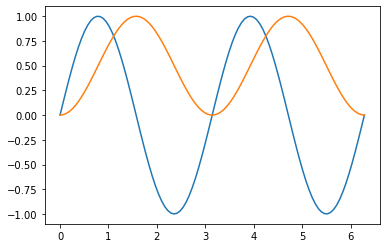

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = tf.constant(np.linspace(0,2*np.pi,100))
with tf.GradientTape() as t:
    t.watch(x)
    y = f(x)
    
g = t.gradient(y,x)
plt.plot(x.numpy(), g.numpy(), x.numpy(), y.numpy())

# Canny edge

Canny, John. "A computational approach to edge detection." IEEE Transactions on pattern analysis and machine intelligence 6 (1986): 679-698. (27000+ citations)
Canny:
-  assume noisy step edges
-  construct an edge detector using an optimal linear filter

This is actually a simple neural network...

In [17]:
# package loading, helper functions

import os
import pickle
import numpy as np
import scipy.ndimage as ndi
import sklearn
import tensorflow.keras 
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

#Source("digraph {X->Y; Y->Z;}")
from graphviz import Source
from scipy.stats import kde
from sklearn import decomposition


def tshow(v, ax=None, **keys):
    if isinstance(v, tf.Tensor):
        v = v.float_val
    if v.ndim == 1:
        v = v.reshape(28, 28)
    if v.ndim == 3 and v.shape[0] == 1:
        v = v[0]
    if v.ndim == 3 and v.shape[2] == 1:
        v = v[:, :, 0]
    if v.ndim == 4:
        v = v[0, 0]
    v = v - amin(v)
    v /= amax(v)
    if ax is not None:
        ax.imshow(v, **keys)
    else:
        imshow(v, **keys)

        
def showrow(*args, **kw):
    figsize(*kw.get("fs", (15, 5)))
    if "fs" in kw:
        del kw["fs"]
    for i, im in enumerate(args):
        subplot(1, len(args), i+1)
        tshow(im, **kw)

def showgrid(images, rows=4, cols=4, cmap=plt.cm.gray, size=(7, 7)):
    if size is not None:
        figsize(*size)
    for i in range(rows*cols):
        subplot(rows, cols, i+1)
        xticks([])
        yticks([])
        tshow(images[i], cmap=cmap)

The Process of Canny edge detection algorithm can be broken down to 5 different steps:

-    Apply Gaussian filter to smooth the image in order to remove the noise
-    Find the intensity gradients of the image
-    Apply non-maximum suppression to get rid of spurious response to edge detection
-    Apply double threshold to determine potential edges
-    Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.



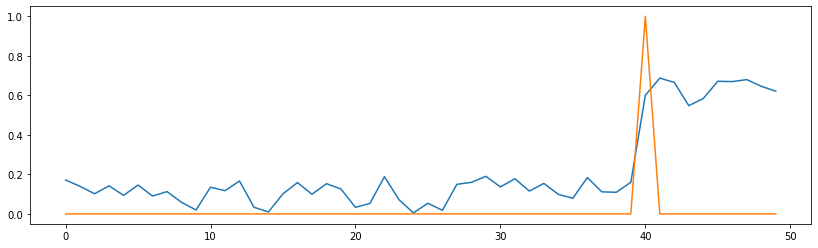

In [18]:
length = 50
pos = np.random.randint(length, size=10000)
signal = np.random.rand(10000,length) / 5
gt = np.zeros((10000,length))

for j,i in enumerate(pos):
    signal[j, i:] = signal[j, i:] + 0.5
    gt[j, i] = 1

figure(figsize=(14,4))
plt.plot(signal[15])
plt.plot(gt[15])

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.optimizers import SGD

In [20]:
# Canny model
model = Sequential()
model.add(Conv1D(1, 33, input_shape=(length, 1), activation="sigmoid", padding='same'))
model.add(Flatten())

model.compile(SGD(lr=.1, momentum=0.9, decay=1e-5), loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 1)             34        
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [21]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = np.expand_dims(signal, 3), y=gt, batch_size=100, epochs=100)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 3.7604
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 3.5679
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3654
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1902
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0376
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 2.8945
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7549
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6178
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4835
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3532
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2279
Epoch 12/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1082
Epoch 13/100


100/100 [==============================] - 0s 3ms/step - loss: 0.2109
Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2086


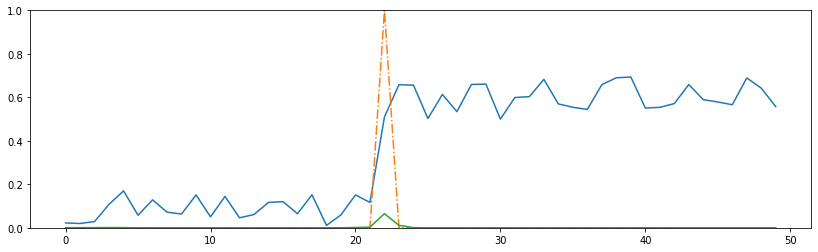

In [22]:
figure(figsize=(14,4))
ylim(ymax=1)

a = 128
plt.plot(signal[a,:].reshape((length)))
plt.plot(gt[a,:], '-.')
plt.plot(model.predict(signal[a,:].reshape((1,length,1))).reshape(length))

## Kanny kernel

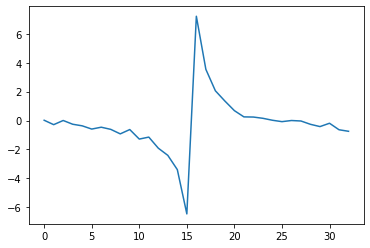

In [23]:
plt.plot(model.get_layer(index=0).get_weights( )[0].flatten())

There is a large and rich theory of linear filters in signal processing and image processing:

    - mathematical properties: superposition, decomposition, impulse response
    - frequency domain analysis
    - optimal design for given tasks

NB: "optimal linear" is not the same as "optimal"

# No free lunch theorem!

A model, a family of function, a neural net architecture+regularizer, a likelihood model+prior, are all forms of inductive bias.
And we know that there is no free lunch, meaning that:
- There is no learning without inductive bias.
- There is no neural net training without an architecture.
- There is no statistical estimation without a likelihood model.
- There is no non-parametric estimation without regularization.

Without some sort of inductive bias
- There is no estimation of probability distribution.
- There is no estimation of entropy.
- There is no estimation of mutual information.
- There is no estimation of conditional independence.
- There is no measure of complexity
- There is no estimation of minimum description length.

Which means that none of these things are well defined quantities (except perhaps in the asymptotic case of infinite data. But who cares about that). 
The estimation of all of these quantities is subjectively dependent upon your choice of model.
You may say: "the entropy of my data is well defined. It's `H = -SUM_x P(x) log P(x)`
Yes, but what is `P(x)`? 
You only know `P(x)` through a bunch of samples. 

Which mean you need to estimate a model of `P(x)` from your data.
Which means your model will necessarily have some sort of inductive bias, some sort of arbitrariness in it.


Ultimately, all measures of distributions, information, entropy, complexity and dependency are in the eye of the beholder.

The subjectivity of those quantities also exists when applied to physical systems. The entropy of a physical system is also in the eyes of the beholder.

In [24]:
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding1D 

In [25]:
# DL model
model = Sequential()
model.add(ZeroPadding1D(input_shape=(length, 1), padding=(8,1)))
model.add(Conv1D(4, 7))
model.add(BatchNormalization(momentum=0.1))
model.add(Activation('relu'))
model.add(ZeroPadding1D(padding=(2,1)))
model.add(Conv1D(1, 7))
model.add(Flatten())
model.add(Activation('sigmoid'))

model.compile(SGD(lr=.1, momentum=0.9, decay=1e-5), loss='categorical_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d (ZeroPadding1 (None, 59, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 53, 4)             32        
_________________________________________________________________
batch_normalization (BatchNo (None, 53, 4)             16        
_________________________________________________________________
activation (Activation)      (None, 53, 4)             0         
_________________________________________________________________
zero_padding1d_1 (ZeroPaddin (None, 56, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 1)             29        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)               

In [26]:
K.set_value(model.optimizer.lr, 1e-3)
model.fit(x = np.expand_dims(signal, 3), 
          y=gt, 
          batch_size=200, 
          epochs=50)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


Epoch 1/50
100/100 [==============================] - 0s 3ms/step - loss: 3.2969
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 1.1412
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.1079
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0440
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 8/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 9/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 10/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 11/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 12/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 13/50
100/100 [====

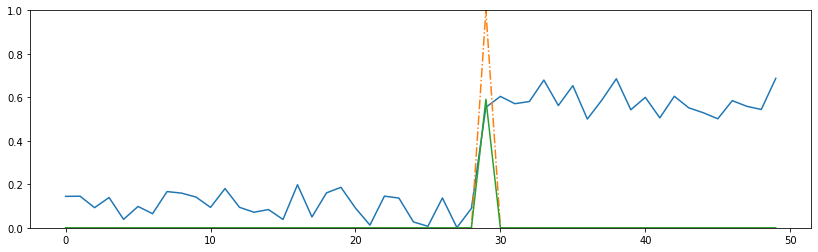

In [27]:
figure(figsize=(14,4))
ylim(ymax=1)
a = 10
plt.plot(signal[a,:].reshape((length)))
plt.plot(gt[a,:], '-.')
plt.plot(model.predict(signal[a,:].reshape((1,length,1))).reshape(length))

In [28]:
for i, l in enumerate(model.layers):
    print (i, l.name)

0 zero_padding1d
1 conv1d_1
2 batch_normalization
3 activation
4 zero_padding1d_1
5 conv1d_2
6 flatten_1
7 activation_1


## How does it works?

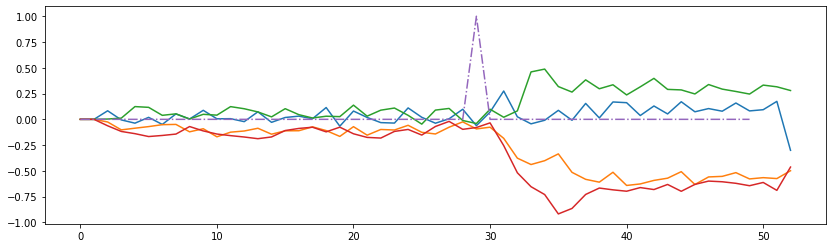

In [29]:
figure(figsize=(14,4))

x = signal[a,:].reshape((1,length,1))
layer = model.layers[1]
f = K.function([model.get_input_at(0)], [layer.get_output_at(0)])
plt.plot(f([x])[0][0,:,:])  # your activation tensor
plt.plot(gt[a,:], '-.')

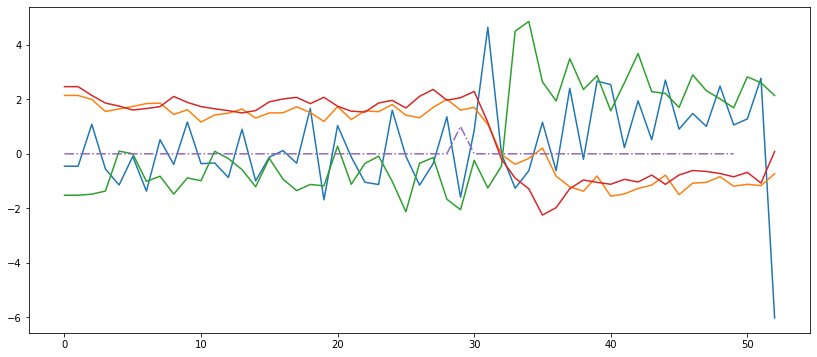

In [30]:
figure(figsize=(14,6))

layer = model.layers[2]
f = K.function([model.get_input_at(0)], [layer.get_output_at(0)])
plt.plot(f([x])[0][0,:,:])  # your activation tensor
plt.plot(gt[a,:], '-.')

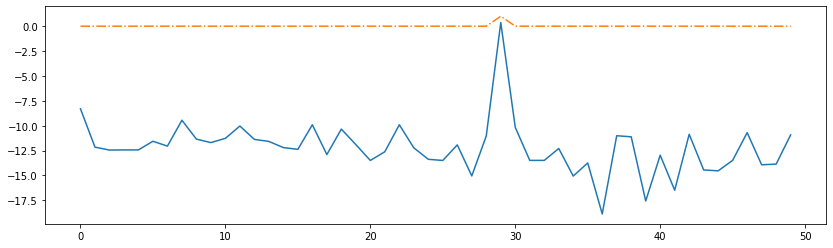

In [31]:
figure(figsize=(14,4))

layer = model.layers[5]
f = K.function([model.get_input_at(0)], [layer.get_output_at(0)])
plt.plot(f([x])[0][0,:,:])  # your activation tensor
plt.plot(gt[a,:], '-.')

- Zero padding on the boundary creates spurious edge responses.
- DL can automatically suppress these for you (beware when benchmarking)
- How would you pick weights to get rid of such spurious responses?

In [32]:
# DL model
model = Sequential()
model.add(ZeroPadding1D(input_shape=(length, 1), padding=(8,1)))
model.add(Conv1D(16, 7))
model.add(BatchNormalization(momentum=0.1))
model.add(Activation('relu'))
model.add(ZeroPadding1D(padding=(2,1)))
model.add(Conv1D(1, 7))
model.add(Flatten())
model.add(Activation('sigmoid'))

model.compile(SGD(lr=1e-2, momentum=0.9, decay=1e-5), loss='categorical_crossentropy')

model.fit(x = np.expand_dims(signal, 3), y=gt, batch_size=200, epochs=50)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


Epoch 1/50
100/100 [==============================] - 1s 5ms/step - loss: 0.5026
Epoch 2/50
100/100 [==============================] - 1s 6ms/step - loss: 0.0022
Epoch 3/50
100/100 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 4/50
100/100 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 5/50
100/100 [==============================] - 1s 5ms/step - loss: 8.6485e-04
Epoch 6/50
100/100 [==============================] - 0s 5ms/step - loss: 7.2397e-04
Epoch 7/50
100/100 [==============================] - 1s 5ms/step - loss: 6.2857e-04
Epoch 8/50
100/100 [==============================] - 1s 5ms/step - loss: 5.5634e-04
Epoch 9/50
100/100 [==============================] - 1s 5ms/step - loss: 4.9643e-04
Epoch 10/50
100/100 [==============================] - 1s 5ms/step - loss: 4.7250e-04
Epoch 11/50
100/100 [==============================] - 1s 5ms/step - loss: 4.2360e-04
Epoch 12/50
100/100 [==============================] - 1s 5ms/step - loss: 3.85

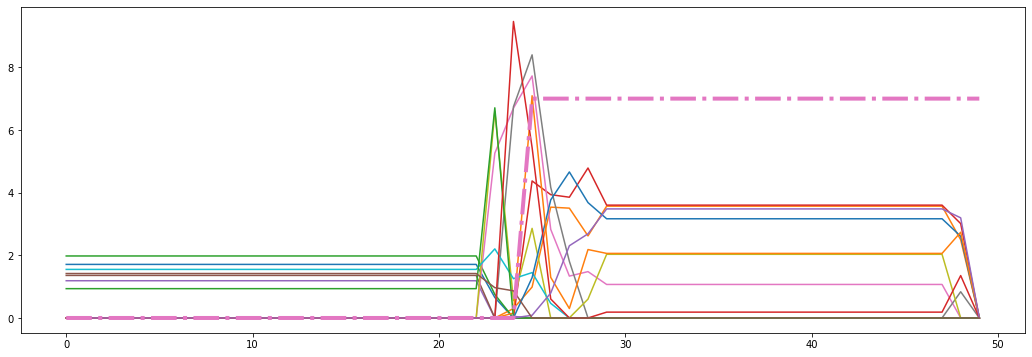

In [33]:
figure(figsize=(18,6))

x = np.zeros(length)
x[int(length/2):] = 1
x = x.reshape((1,length,1))

layer = model.layers[4]
f = K.function([model.get_input_at(0)], [layer.get_output_at(0)])
plt.plot(f([x])[0][0,6:,:])  # your activation tensor
plt.plot(7*x.flatten(), '-.', linewidth=4)

- DL discovered another neat trick: Instead of a single edge localizer, train two localization filters in the first layer (plus multiple suppression filters again).
- Each localization filter is offset from the desired peak by one pixel.
- The padding on the second convolutional layer means that the spurious
edges on the boundary are only surrounded by one peak.

# SVM 

 Let's try to implement a standard L2-regularized support vector machine (SVM)
 
 ![smv](figures/L.png)
 
 where:
 
 ![](figures/D.png)

In [34]:
from sklearn import svm
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1L2
import tensorflow.keras.backend as K

In [35]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) > .5
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


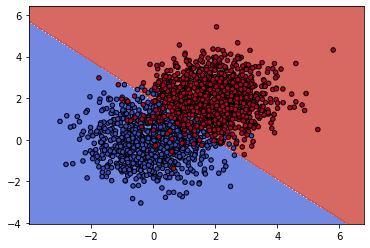

In [36]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 1000
X = np.r_[1. * rng.randn(n_samples_1, 2),
          1. * rng.randn(n_samples_2, 2) + [2, 2]]
y = [0] * (n_samples_1) + [1] * (n_samples_2)

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
model  = svm.LinearSVC(C=C)
clf = model.fit(X, y)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(plt, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.show()

In [37]:
def hinge(y_true, y_pred):
    return K.mean(K.maximum(1. - y_true * y_pred, 0.), axis=-1)

l2 = 1/float(C)
inputs = Input(shape=(2,))
x = Dense(1, activation=None, kernel_regularizer=L1L2(l1=0,l2=l2))(inputs)
predictions = Activation('linear')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='sgd',
              loss=hinge,
              metrics=['accuracy'])

model.summary()

# Wx + b

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [38]:
K.set_value(model.optimizer.lr, 1e-3)
history = model.fit(x=X, y=np.array(y), 
                    batch_size=100, 
                    epochs=100, 
                    shuffle=True, 
                    validation_split=.3)

Epoch 1/100
14/14 [==============================] - 0s 14ms/step - loss: 3.8389 - accuracy: 0.4507 - val_loss: 6.2210 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 3.6745 - accuracy: 0.4536 - val_loss: 5.9683 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 3.5189 - accuracy: 0.4564 - val_loss: 5.7268 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 3.3718 - accuracy: 0.4579 - val_loss: 5.4958 - val_accuracy: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 3.2326 - accuracy: 0.4600 - val_loss: 5.2750 - val_accuracy: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 3.1010 - accuracy: 0.4607 - val_loss: 5.0638 - val_accuracy: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 2.9764 - accuracy: 0.4636 - val_loss: 4.8616 - val_accur

Epoch 58/100
14/14 [==============================] - 0s 4ms/step - loss: 0.9007 - accuracy: 0.7586 - val_loss: 0.6020 - val_accuracy: 0.2183
Epoch 59/100
14/14 [==============================] - 0s 5ms/step - loss: 0.8928 - accuracy: 0.7871 - val_loss: 0.5732 - val_accuracy: 0.3117
Epoch 60/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8854 - accuracy: 0.8100 - val_loss: 0.5453 - val_accuracy: 0.3967
Epoch 61/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8782 - accuracy: 0.8300 - val_loss: 0.5183 - val_accuracy: 0.4650
Epoch 62/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8714 - accuracy: 0.8493 - val_loss: 0.4920 - val_accuracy: 0.5433
Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8650 - accuracy: 0.8636 - val_loss: 0.4665 - val_accuracy: 0.6183
Epoch 64/100
14/14 [==============================] - 0s 2ms/step - loss: 0.8588 - accuracy: 0.8779 - val_loss: 0.4418 - val_accuracy: 0.7017
Epoch 

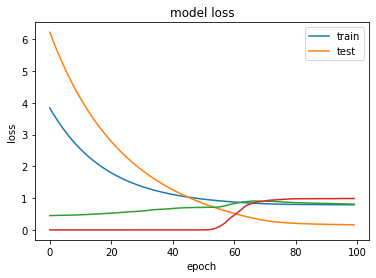

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

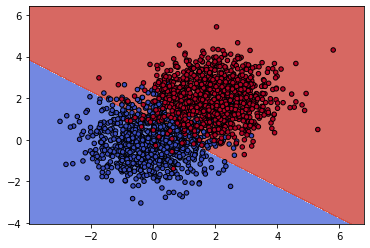

In [40]:
plot_contours(plt, model, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# IIR Filters and their DL Equivalents

In [ ]:
# simple IIR filter

def simple_iir(xs):
    value = xs[0]
    output = zeros(len(xs))
    for i in range(len(xs)):
        output[i] = value
        value = 0.7 * value + 0.3 * xs[i]
    return output

In [ ]:
xs = rand(100) * (rand(100) < 0.1)

figure(figsize=(14,5))
plot(xs)
plot(simple_iir(xs))

## IIR Filters

IIR filters are simple linear filters.

Unlike FIR filters, the output is a linear function of both inputs and past output values.

IIR filters can approximate FIR filters well.

IIR filters are the linear equivalent of *recurrent neural networks*.


In [ ]:
inputs = array([(rand(200) < 0.1).astype('f') for i in range(10000)]).reshape(-1, 1, 200)
outputs = array([4.0*ndi.gaussian_filter(s, 3.0) for s in inputs]).reshape(-1, 1, 200)

figure(figsize=(14,5))
plot(inputs[0,0]); plot(outputs[0,0])

### Simple NN

In [ ]:
length = 200

model = Sequential()
model.add(Conv1D(1, 33, input_shape=(length, 1), activation="sigmoid", padding='same'))
model.add(Flatten())

model.compile(SGD(lr=.1, momentum=0.9, decay=1e-5), loss='mse')
model.summary()

In [ ]:
#K.set_value(model.optimizer.lr, 1e-2)
model.fit(x=inputs.reshape((-1, 200,1)), y=outputs.reshape((-1, 200)), batch_size=100, epochs=100)

In [ ]:
pred = model.predict(inputs.reshape((-1, 200,1)))

figure(figsize=(15,5))
plot(inputs[0,0])
plot(pred[0], linewidth=2, color="green")
plot(outputs[0,0], linewidth=8, alpha=0.3, color="red")

### Recurrent neural network - LSTM

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional

In [ ]:
length = 200

model = Sequential()
model.add(Bidirectional(LSTM(4, input_shape=(length, 1), activation="sigmoid", return_sequences=True)))
model.add(Conv1D(1, 8, padding='same'))

model.compile(SGD(lr=.1, momentum=0.9, decay=1e-5), loss='mse')
model.build(input_shape=(None, 200,1))

In [ ]:
model.summary()

In [ ]:
K.set_value(model.optimizer.lr, 1e-1)
model.fit(x=inputs.reshape((-1, 200,1)), 
          y=outputs.reshape((-1, 200,1)), 
          batch_size=1000, 
          epochs=15)

In [ ]:
pred = model.predict(inputs.reshape((-1, 200,1)))

figure(figsize=(15,5))
plot(inputs[0,0])
plot(pred[0], linewidth=2, color="green")
plot(outputs[0,0], linewidth=8, alpha=0.3, color="red")

# Handsome input pipelines with the `tf.data` API 

The `tf.data` API offers functions for data pipelining and related operations. We can build pipelines, map preprocessing functions, shuffle or batch a dataset and much more.

## From tensors

In [5]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
iter(dataset).next().numpy()

8

## Batch and Shuffle

In [10]:
# Shuffle
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).shuffle(6)
iter(dataset).next().numpy()

2

In [11]:
# Batch
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).batch(2)
iter(dataset).next().numpy()

array([8, 3], dtype=int32)

In [12]:
# Shuffle and Batch
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).shuffle(6).batch(2)
iter(dataset).next().numpy()

array([1, 2], dtype=int32)

## Zipping Two Datsets

In [13]:
dataset0 = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset1 = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
dataset = tf.data.Dataset.zip((dataset0, dataset1))
iter(dataset).next()

(<tf.Tensor: shape=(), dtype=int32, numpy=8>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

## Mapping External Functions

In [15]:
def into_2(num):
     return num * 2

dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1]).map(into_2)

## ImageDataGenerator

This is one of the best features of the `tensorflow.keras` API (in my opinion). The `ImageDataGenerator` is capable of generating dataset slices while batching and preprocessing along with data augmentation in real-time.

The Generator allows data flow directly from directories or from dataframes.

A misconception about data augmentation in `ImageDataGenerator` is that, it adds more data to the existing dataset. Although that is the actual definition of data augmentation, in `ImageDataGenerator`, the images in the dataset are transformed dynamically at different steps in training so that the model can be trained on noisy data it hasn’t seen.

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)

Here, the rescaling is done on all the samples (for normalizing), while the other parameters are for augmentation.

In [33]:
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary'
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

# Custom Layers

Neural Nets are known for many layer deep networks wherein the layers can be of different types. TensorFlow contains many predefined layers (like Dense, LSTM, etc.). But for more complex architectures, the logic of a layer is much more complex than a primary layer. For such instances, TensorFlow allows building custom layers. This can be done by subclassing the tf.keras.layers.Layer class.

In [34]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(CustomDense, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[int(input_shape[-1]),
            self.num_outputs]
        )

    def call(self, input):
        return tf.matmul(input, self.kernel)

As stated in the documentation, The best way to implement your own layer is extending the `tf.keras.Layer` class and implementing:

-    `__init__` , where you can do all input-independent initialization.
-    `build`, where you know the shapes of the input tensors and can do the rest of the initialization.
-    `call`, where you do the forward computation.

Although the kernel initialization can be done in `__init__` itself, it is considered better to be initialized in build as otherwise, you would have to explicitly specify the input_shape on every instance of a new layer creation.

# Custom Training

The `tf.keras` Sequential and the Model API makes training models easier. However, most of the time while training complex models, custom loss functions are used. Moreover, the model training can also differ from the default (for eg. applying gradients separately to different model components).

TensorFlow’s automatic differentiation helps calculating gradients in an efficient way. These primitives are used in defining custom training loops.



In [ ]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        # Computing Losses from Model Prediction
        current_loss = loss(outputs, model(inputs))          # Gradients for Trainable Variables with Obtained Losses
    dW, db = t.gradient(current_loss, [model.W, model.b])    # Applying Gradients to Weights
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

This loop can be repeated for multiple epochs and with a more customised setting as per the use case.

# Autoencoders

predict the input, given that same input. 

\begin{equation}\label{eq:}
F_{W,b}(x) \approx x
\end{equation}

The goal is to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.